The main() function orchestrates the execution of these steps. **---** It loads and transforms the data, creates a graph from a polygon, consolidates intersections, saves the graph to a file, converts the graph to GeoDataFrames, saves nodes and edges to files, loads farm data, loads H3 GeoDataFrame, finds the closest OSM ID for each point in the GeoDataFrames, loads farm GeoDataFrame, loads loi data, loads H3 GeoDataFrame, filters H3 GeoDataFrame, and finally calculates the OD matrix. **---** The script is designed to be run as a **standalone program.**

In [181]:
# Import necessary libraries
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points
import pprint

from utils.cflp_function import *
from utils.calculate_od import *

In [182]:
# Define constants
SHAPEFILE_PATH = "../shapefiles/zh_poly/zh_poly.shp"
CUSTOM_FILTER = '["highway"]["area"!~"yes"]["access"!~"private"]["highway"~"motorway|motorway_link|trunk|trunk_link|primary|primary_link|secondary|secondary_link|tertiary|tertiary_link|road"]'
H3_GDF_FILEPATH = '../app_data/h3_pzh_polygons.shp'
TO_CRS = "EPSG:4326"
GRAPHML_FILEPATH = "../osm_network/extracts/G.graphml"
NODES_FILEPATH = "../osm_network/extracts/G_n.shp"
EDGES_FILEPATH = "../osm_network/extracts/G_e.shp"
FARM_FILEPATH = '../farm/pzh_farms.shp'
APP_DATA_H3_GEOMETRY_FILEPATH = "../app_data/h3_geometry.shp"
APP_DATA_FARM_FILEPATH = "../app_data/farm.shp"
LOI_FILEPATH = '../hex/loi.csv'
COST_PER_KM = 0.69

This function loads geospatial data from a file and transforms the Coordinate Reference System (CRS) to the specified CRS.

In [183]:
def load_and_transform_data(file_path, to_crs="EPSG:4326"):
    """Load geospatial data from a file and transform the Coordinate Reference System (CRS) to the specified CRS."""
    data = gpd.read_file(file_path)
    data = data.to_crs(to_crs)
    return data

This function creates a graph from a polygon, which represents the study area. The graph is created based on a specified network type and custom filter, and is then projected to the specified CRS.

In [184]:
def create_graph_from_polygon(polygon, network_type, custom_filter):
    """Create a graph from a polygon, which represents the study area."""
    G_base = ox.graph_from_polygon(polygon, network_type=network_type, custom_filter=custom_filter)
    G_base = ox.project_graph(G_base, to_crs="EPSG:3857")
    return G_base

 This function simplifies the topology of the graph by consolidating intersections within a specified tolerance.

In [185]:
def consolidate_intersections(G_base, tolerance, rebuild_graph=True, dead_ends=False):
    """Simplify the topology of the graph by consolidating intersections within a specified tolerance."""
    G = ox.consolidate_intersections(G_base, tolerance=tolerance, rebuild_graph=rebuild_graph, dead_ends=dead_ends)
    return G

This function saves the graph to a file.

In [186]:
def save_graph_to_file(G, filepath):
    """Save the graph to a file."""
    ox.save_graphml(G, filepath=filepath, gephi=False)

This function converts lists to strings in the ‘highway’ column of the edges GeoDataFrame.

In [187]:
def convert_lists_to_strings(e):
    """Convert lists to strings in the ‘highway’ column of the edges GeoDataFrame."""
    e['highway'] = e['highway'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

In [188]:
def save_nodes_and_edges_to_files(nodes_gdf, edges_gdf, nodes_filepath, edges_filepath):
    """Save nodes and edges GeoDataFrames to files."""
    nodes_gdf[["geometry", "y", "x", "lon", "lat", "highway"]].to_file(nodes_filepath)
    edges_gdf[["geometry","highway"]].to_file(edges_filepath)

In [189]:
def ensure_point_geometry(gdf):
    """Ensure the geometry is of Point type."""
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.centroid if geom.geom_type != 'Point' else geom)
    return gdf

In [190]:
def save_transformed_data(h3_geodataframe, farm_data, nodes_geodataframe, h3_filepath, farm_filepath):
    """Save transformed data."""
    h3_geodataframe = ensure_point_geometry(h3_geodataframe)
    farm_data = ensure_point_geometry(farm_data)

    """Find the closest OSM ID for each point in the GeoDataFrames."""
    find_closest_osmid(h3_geodataframe, nodes_geodataframe)
    find_closest_osmid(farm_data, nodes_geodataframe)

    """Transform CRS and calculate centroids."""
    h3_geodataframe = h3_geodataframe.to_crs("EPSG:28992")
    h3_geodataframe['geometry'] = h3_geodataframe['geometry'].centroid
    h3_geodataframe['y'] = h3_geodataframe['geometry'].y
    h3_geodataframe['x'] = h3_geodataframe['geometry'].x

    """Save GeoDataFrames to files."""
    h3_geodataframe.to_file(h3_filepath)
    farm_data.to_file(farm_filepath)

The main() function orchestrates the execution of these steps. It loads and transforms the data, creates a graph from a polygon, consolidates intersections, saves the graph to a file, converts the graph to GeoDataFrames, saves nodes and edges to files, loads farm data, loads H3 GeoDataFrame, finds the closest OSM ID for each point in the GeoDataFrames, loads farm GeoDataFrame, loads loi data, loads H3 GeoDataFrame, filters H3 GeoDataFrame, and finally calculates the OD matrix.

In [191]:
def main():
    """Main function to orchestrate the execution of the steps."""
    # Load and transform data
    polygon_data = load_and_transform_data(SHAPEFILE_PATH)
    study_area_polygon = polygon_data['geometry'].squeeze()

    # Create and process graph from polygon
    base_graph = create_graph_from_polygon(study_area_polygon, 'drive', CUSTOM_FILTER)
    print("Number of nodes in the base graph:", len(base_graph.nodes))
    print("Number of edges in the base graph:", len(base_graph.edges))

    tolerance = 200  # adjustable value
    processed_graph = consolidate_intersections(base_graph, tolerance=tolerance, rebuild_graph=True, dead_ends=False)


    # Plot and save base graph
    fig, ax = ox.plot_graph(base_graph, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')
    fig.savefig("../osm_network/Diagram/base_graph.png", format = 'png', dpi= 1000, bbox_inches="tight")

    # Plot and save processed graph (using processed_graph directly)
    fig, ax = ox.plot_graph(processed_graph, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')
    fig.savefig("../osm_network/Diagram/processed_graph.png", format = 'png', dpi= 1000, bbox_inches="tight")


    # Save graph to file and convert to GeoDataFrames
    save_graph_to_file(processed_graph, GRAPHML_FILEPATH)
    nodes_geodataframe, edges_geodataframe = ox.graph_to_gdfs(processed_graph)
    
    # Convert lists to strings in the 'highway' column of the edges GeoDataFrame
    convert_lists_to_strings(edges_geodataframe)

    # Save nodes and edges to files
    save_nodes_and_edges_to_files(nodes_geodataframe, edges_geodataframe, NODES_FILEPATH, EDGES_FILEPATH)

    # Load farm data and H3 GeoDataFrame
    farm_data = load_and_transform_data(FARM_FILEPATH)
    h3_geodataframe = load_and_transform_data(H3_GDF_FILEPATH)

    # Save transformed data
    save_transformed_data(h3_geodataframe, farm_data, nodes_geodataframe, APP_DATA_H3_GEOMETRY_FILEPATH, APP_DATA_FARM_FILEPATH)

    # Load farm GeoDataFrame and loi data
    farm_geodataframe = gpd.read_file(APP_DATA_FARM_FILEPATH)
    loi_data = gpd.read_file(LOI_FILEPATH)

    # Load H3 GeoDataFrame and filter it
    h3_geodataframe = gpd.read_file(APP_DATA_H3_GEOMETRY_FILEPATH)
    filtered_loi_geodataframe = h3_geodataframe[h3_geodataframe['hex9'].isin(loi_data.hex9)]

    # Calculate OD matrix
    cost_matrix, plant_list = calculate_od_matrix(farm_geodataframe, filtered_loi_geodataframe, COST_PER_KM)

    print("Cost Matrix: ")
    pprint.pprint(cost_matrix)
    print("Plant List: ")
    pprint.pprint(plant_list)

    print('end')

Number of nodes in the base graph: 15091
Number of edges in the base graph: 27402


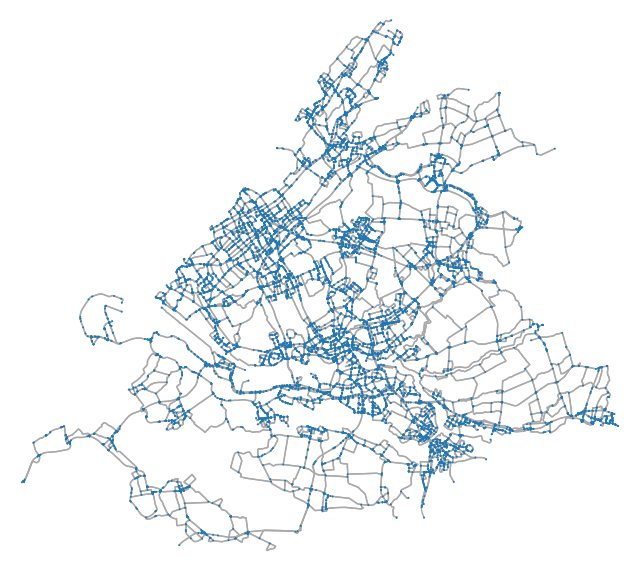

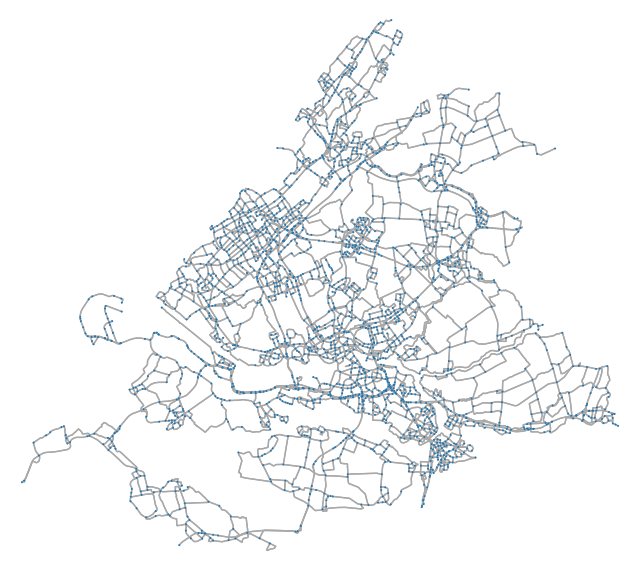

                  hex9                  geometry  \
0      89196ba7197ffff  POINT (4.51083 51.81352)   
1      89196ba1167ffff  POINT (4.29334 51.85681)   
2      89196b1718fffff  POINT (3.99857 51.99327)   
3      891969451bbffff  POINT (4.86372 52.06441)   
4      891969615afffff  POINT (4.92491 51.84363)   
...                ...                       ...   
37137  8919696342bffff  POINT (4.95327 51.89683)   
37138  89196979863ffff  POINT (4.75999 51.89009)   
37139  89196bb560bffff  POINT (4.48535 51.92583)   
37140  89196b06c43ffff  POINT (3.99285 51.83029)   
37141  89196949623ffff  POINT (4.44550 52.15387)   

                                           closest_osmid  
0      [45395854, 45395426, 45395850, 607957903, 4539...  
1      [1559586807, 1812916533, 44564333, 1559586808,...  
2                                               44468388  
3                                               44411090  
4      [44357073, 681673208, 44362220, 681673215, 681...  
...                  

/tmp/ipykernel_7756/800107188.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  h3_geodataframe.to_file(h3_filepath)
/tmp/ipykernel_7756/800107188.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  farm_data.to_file(farm_filepath)


FileNotFoundError: [Errno 2] No such file or directory: 'osm_network/G.graphml'

In [192]:
if __name__ == "__main__":
    main()